In [8]:
# Importando as bibliotecas necessárias
import pandas as pd
import requests
import io
import tarfile
import os
import json 
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

# Para testes estatísticos
from scipy.stats import ttest_ind

In [9]:
# Dataframe do ab test
ab_test_url = 'https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz'
response = requests.get(ab_test_url)
tar = tarfile.open(fileobj=io.BytesIO(response.content))
tar.extractall(path='.')  # Extrai os arquivos para o diretório atual
arquivos_extraidos = tar.getnames()
df_ab_test = pd.read_csv('ab_test_ref.csv')

In [10]:
# Dataframe do arquivo consumer
consumers_url = 'https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz'
df_consumer = pd.read_csv(consumers_url)

In [11]:
# Dataframe do arquivo restaurantes
restaurant_url = 'https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz'
df_restaurant = pd.read_csv(restaurant_url)

In [12]:
print(f"Total de linhas no df_ab_test: {df_ab_test.shape[0]}")
print(f"Total de linhas no df_consumer: {df_consumer.shape[0]}")
print(f"Total de linhas no df_restaurant: {df_restaurant.shape[0]}")

Total de linhas no df_ab_test: 806467
Total de linhas no df_consumer: 806156
Total de linhas no df_restaurant: 7292


In [13]:
# Fazendo a extração do json separado
input_file = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz"

In [14]:
# Pegando amostra do json para ver se está no formato correto e ver quais informações utilizar
df_order_sample = pd.read_json(input_file, lines=True, nrows=1000)
print(df_order_sample.columns)
df_order_sample.head(5)

Index(['cpf', 'customer_id', 'customer_name', 'delivery_address_city',
       'delivery_address_country', 'delivery_address_district',
       'delivery_address_external_id', 'delivery_address_latitude',
       'delivery_address_longitude', 'delivery_address_state',
       'delivery_address_zip_code', 'items', 'merchant_id',
       'merchant_latitude', 'merchant_longitude', 'merchant_timezone',
       'order_created_at', 'order_id', 'order_scheduled', 'order_total_amount',
       'origin_platform', 'order_scheduled_date'],
      dtype='object')


,cpf,customer_id,customer_name,delivery_address_city,delivery_address_country,delivery_address_district,delivery_address_external_id,delivery_address_latitude,delivery_address_longitude,delivery_address_state,...,merchant_id,merchant_latitude,merchant_longitude,merchant_timezone,order_created_at,order_id,order_scheduled,order_total_amount,origin_platform,order_scheduled_date
0,80532101763,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,GUSTAVO,FRANCA,BR,JARDIM ESPRAIADO,6736655,-47.39,-20.55,SP,...,a992a079a651e699d9149423761df2427c0e3af0a2a1b5...,-47.39,-20.55,America/Sao_Paulo,2019-01-17 22:50:06+00:00,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,False,46.0,ANDROID,NaN
1,43352103961,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,MICHELLE,SANTOS,BR,CAMPO GRANDE,8759216,-46.34,-23.96,SP,...,5152f28ee0518b8803ccf0a4096eb2ff8b81e9491861c9...,-46.34,-23.96,America/Sao_Paulo,2019-01-17 17:51:26+00:00,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,False,104.5,ANDROID,NaN
2,38650991217,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,VICTOR,GUARULHOS,BR,JARDIM ROSSI,8765930,-46.53,-23.44,SP,...,b6096419455c35d06105a5ef0d25c51f9dd40e1e99ac33...,-46.53,-23.44,America/Sao_Paulo,2019-01-17 22:53:47+00:00,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,False,35.0,IOS,NaN
3,63579726866,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,ANNIE,SAO PAULO,BR,PARQUE SAO JORGE,7834087,-46.57,-23.53,SP,...,082bfdcdf6ccdc343e3c4d25ee376b5b6ca7e96ad8b04e...,-46.57,-23.53,America/Sao_Paulo,2019-01-17 23:56:53+00:00,b4df94142d21354611247da9ca94f870c09b93989b531a...,False,40.8,IOS,NaN
4,90617788806,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,DANIEL,VITORIA,BR,JARDIM CAMBURI,7211683,-40.27,-20.25,ES,...,d7adb764bac29ccb77fb8f746ffbd531bf05ec30a7e130...,-40.27,-20.25,America/Sao_Paulo,2019-01-17 23:40:53+00:00,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,False,48.5,ANDROID,NaN


##### Selecionando Colunas para fazer a Análise
- customer_id (string): Identificador do usuário
- delivery_address_city (string): Cidade de entrega do pedido
- delivery_address_country (string): País da entrega
- delivery_address_state (string): Estado da entrega
- merchant_id (string): Identificador do restaurante
- order_created_at (timestamp): Data e hora em que o pedido foi criado
- order_id (string): Identificador do pedido
- order_total_amount (float): Valor total do pedido em Reais

##### Colunas descartadas desta primeira análise e, também, para evitar processamento da base
- cpf (string): Cadastro de Pessoa Física do usuário que realizou o pedido
- customer_name (string): Primeiro nome do usuár
- delivery_address_district (string): Bairro da entrega
- delivery_address_external_id (string): Identificador do endereço de entrega
- delivery_address_latitude (float): Latitude do endereço de entrega
- delivery_address_longitude (float): Longitude do endereço de entrega
- delivery_address_zip_code (string): CEP da entrega
- items (array[json]): Itens que compõem o pedido, bem como informações complementares como preço unitário, quantidade, etc.
- merchant_latitude (float): Latitude do restaurante
- merchant_longitude (float): Longitude do restaurante
- merchant_timezone (string): Fuso horário em que o restaurante está localizado
- order_scheduled (bool): Flag indicando se o pedido foi agendado ou não (pedidos agendados são aqueles que o usuário escolheu uma data e hora para a entrega)
- origin_platform (string): Sistema operacional do dispositivo do usuário
- order_scheduled_date (timestamp): Data e horário para entrega do pedido agendado

In [15]:
desired_cols = [
    "customer_id",
    "delivery_address_city",
    "delivery_address_country",
    "delivery_address_state",
    "merchant_id",
    "order_created_at",
    "order_id",
    "order_total_amount"
]

In [16]:
# Preparando o Chunks e processar a base mais rápido 
chunks = []

for chunk in pd.read_json(input_file, lines=True, chunksize=100000):
    inicio_chunk = time.time()  # Tempo antes de processar o chunk
    chunks.append(chunk[desired_cols])
    fim_chunk = time.time()  # Tempo após processar o chunk
    print(f"Processamento deste chunk levou: {fim_chunk - inicio_chunk:.2f} segundos")

Processamento deste chunk levou: 0.05 segundos
Processamento deste chunk levou: 0.02 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.02 segundos
Processamento deste chunk levou: 0.04 segundos
Processamento deste chunk levou: 0.02 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento deste chunk levou: 0.03 segundos
Processamento

In [17]:
# Verificando a volumetria dada no arquivo json do case
df_orders = pd.concat(chunks, ignore_index=True)
df_orders.shape
print(f"Total de linhas no df orders final: {df_orders.shape[0]}")

Total de linhas no df orders final: 3670826


### Respondendo a primeira pergunta e pegando algumas informações relevantes

In [18]:
# Merge dos dados de pedidos com a marcação do teste A/B
# A união é feita pela coluna 'customer_id'
orders_ab = pd.merge(df_orders, df_ab_test, on='customer_id', how='inner')

# Verificando as primeiras linhas para confirmar a junção
orders_ab.info()
orders_ab.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670826 entries, 0 to 3670825
Data columns (total 9 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   customer_id               object             
 1   delivery_address_city     object             
 2   delivery_address_country  object             
 3   delivery_address_state    object             
 4   merchant_id               object             
 5   order_created_at          datetime64[ns, UTC]
 6   order_id                  object             
 7   order_total_amount        float64            
 8   is_target                 object             
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 252.1+ MB


,customer_id,delivery_address_city,delivery_address_country,delivery_address_state,merchant_id,order_created_at,order_id,order_total_amount,is_target
0,7ba88a68bb2a3504c6bd37a707af57a0b8d6e110a551c7...,FRANCA,BR,SP,a992a079a651e699d9149423761df2427c0e3af0a2a1b5...,2019-01-17 22:50:06+00:00,33e0612d62e5eb42aba15b58413137e441fbe906de2feb...,46.0,control
1,078acecdcf7fa89d356bfa349f14a8219db1ee161ce28a...,SANTOS,BR,SP,5152f28ee0518b8803ccf0a4096eb2ff8b81e9491861c9...,2019-01-17 17:51:26+00:00,148c4353a2952f3fe7973547283265eb22b575fb712ed2...,104.5,control
2,0e38a3237b5946e8ab2367b4f1a3ae6e77f1e215bc760c...,GUARULHOS,BR,SP,b6096419455c35d06105a5ef0d25c51f9dd40e1e99ac33...,2019-01-17 22:53:47+00:00,c37e495a91b498bb7b70a9e09ac115d0cdd443f152dc11...,35.0,control
3,cab1a004b7206d07910092c515a79834fea0a03d7d9054...,SAO PAULO,BR,SP,082bfdcdf6ccdc343e3c4d25ee376b5b6ca7e96ad8b04e...,2019-01-17 23:56:53+00:00,b4df94142d21354611247da9ca94f870c09b93989b531a...,40.8,control
4,aa7edf5b166b8c843aec3b96dc561222888734f3879123...,VITORIA,BR,ES,d7adb764bac29ccb77fb8f746ffbd531bf05ec30a7e130...,2019-01-17 23:40:53+00:00,4ff64b33b272c1886df21b63272220af6a82d1667dba70...,48.5,target


In [19]:
# Agregando métricas por grupo do teste A/B sobre o grupo cotrole e target
group_metrics = orders_ab.groupby('is_target').agg(
    total_orders=('order_id', 'count'),
    total_revenue=('order_total_amount', 'sum'),
    avg_order_value=('order_total_amount', 'mean'),
    unique_customers=('customer_id', 'nunique')
).reset_index()

print(group_metrics)


  is_target  total_orders  total_revenue  avg_order_value  unique_customers
0   control       1525576   7.307187e+07        47.897891            360542
1    target       2145250   1.027609e+08        47.901594            445924


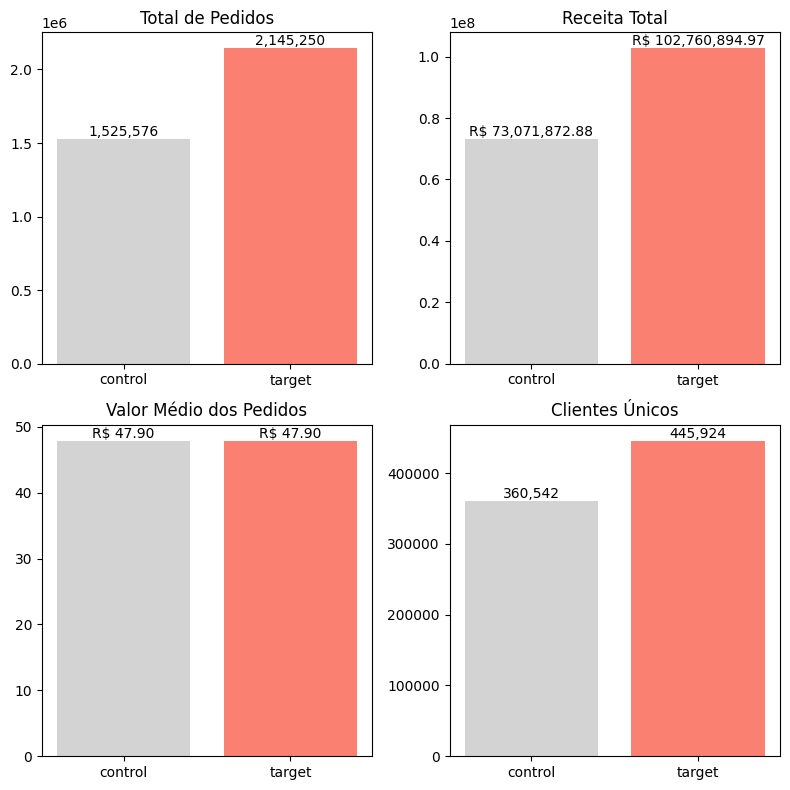

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Total de Pedidos
axes[0, 0].bar(group_metrics['is_target'], group_metrics['total_orders'], color=['lightgray', 'salmon'])
axes[0, 0].set_title('Total de Pedidos')
for i, v in enumerate(group_metrics['total_orders']):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

#Receita Total
axes[0, 1].bar(group_metrics['is_target'], group_metrics['total_revenue'], color=['lightgray', 'salmon'])
axes[0, 1].set_title('Receita Total')
for i, v in enumerate(group_metrics['total_revenue']):
    axes[0, 1].text(i, v, f'R$ {v:,.2f}', ha='center', va='bottom')

# Valor Médio dos Pedidos
axes[1, 0].bar(group_metrics['is_target'], group_metrics['avg_order_value'], color=['lightgray', 'salmon'])
axes[1, 0].set_title('Valor Médio dos Pedidos')
for i, v in enumerate(group_metrics['avg_order_value']):
    axes[1, 0].text(i, v, f'R$ {v:.2f}', ha='center', va='bottom')

# Clientes Únicos
axes[1, 1].bar(group_metrics['is_target'], group_metrics['unique_customers'], color=['lightgray', 'salmon'])
axes[1, 1].set_title('Clientes Únicos')
for i, v in enumerate(group_metrics['unique_customers']):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2637/2578942171.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  orders_ab['order_month'] = orders_ab['order_created_at'].dt.to_period('M').astype(str)


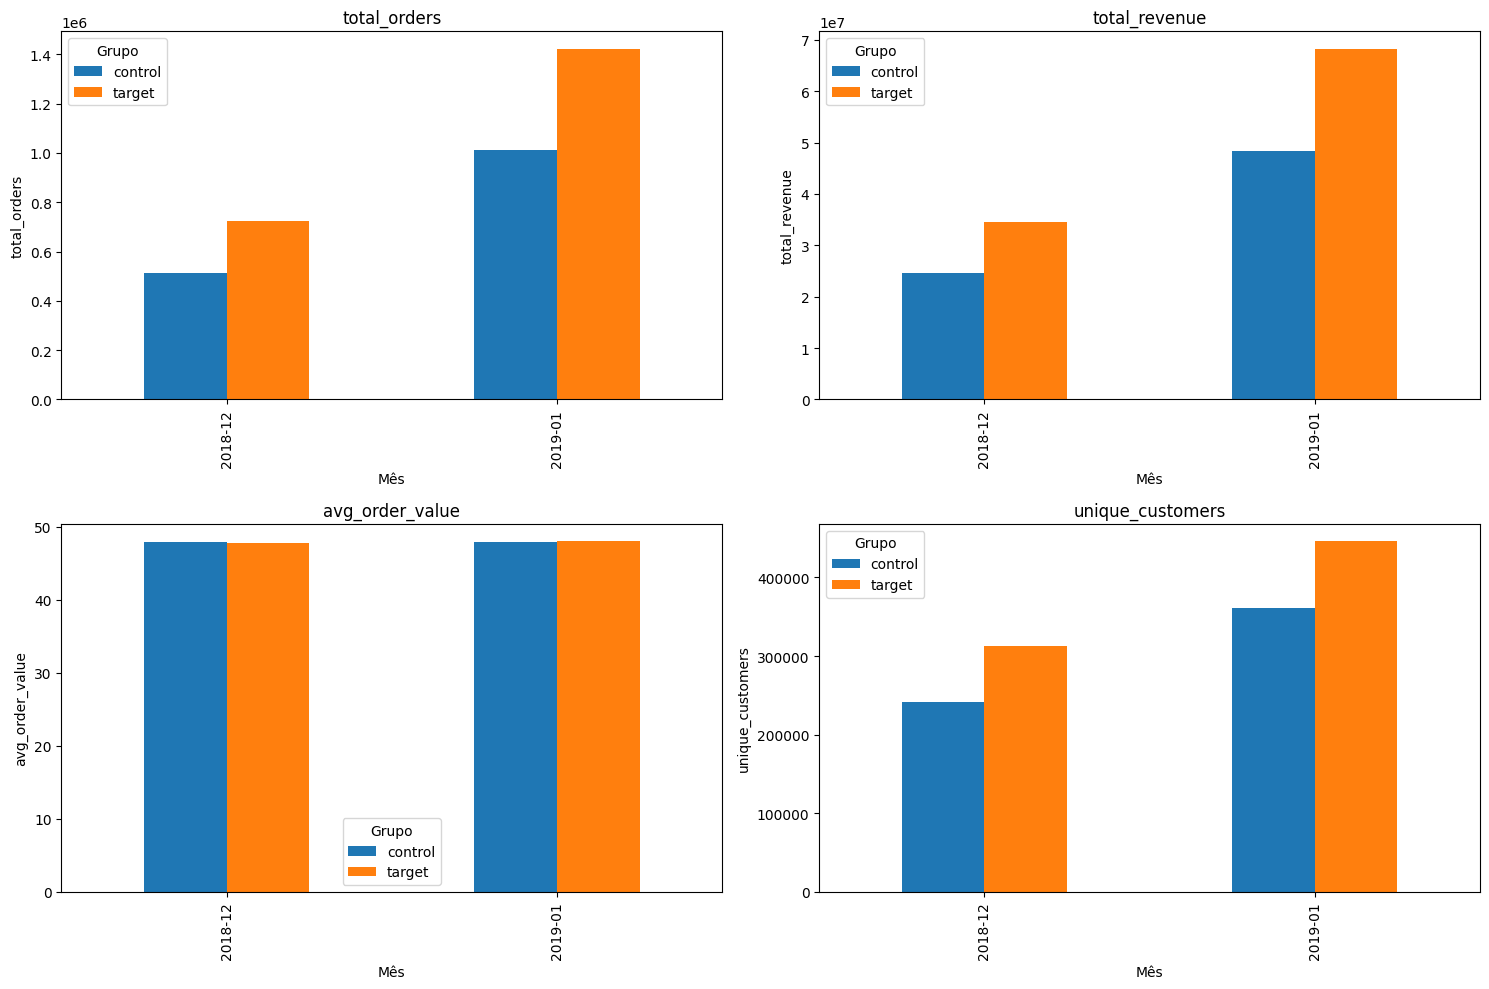

In [21]:
# Certifique-se de que a coluna de data esteja no formato datetime
orders_ab['order_created_at'] = pd.to_datetime(orders_ab['order_created_at'])
# Extraindo o ano e o mês como string (ex.: "2019-01")
orders_ab['order_month'] = orders_ab['order_created_at'].dt.to_period('M').astype(str)

# Agrupando as métricas por mês e grupo do teste
monthly_metrics = orders_ab.groupby(['order_month', 'is_target']).agg(
    total_orders=('order_id', 'count'),
    total_revenue=('order_total_amount', 'sum'),
    avg_order_value=('order_total_amount', 'mean'),
    unique_customers=('customer_id', 'nunique')
).reset_index()

# Lista de métricas para plotar
metrics = ['total_orders', 'total_revenue', 'avg_order_value', 'unique_customers']

# Criando subplots para melhor visão
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    df_pivot = monthly_metrics.pivot(index='order_month', columns='is_target', values=metric)
    df_pivot.plot(kind='bar', ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('Mês')
    ax.set_ylabel(metric)
    ax.legend(title='Grupo')
    
plt.tight_layout()
plt.show()


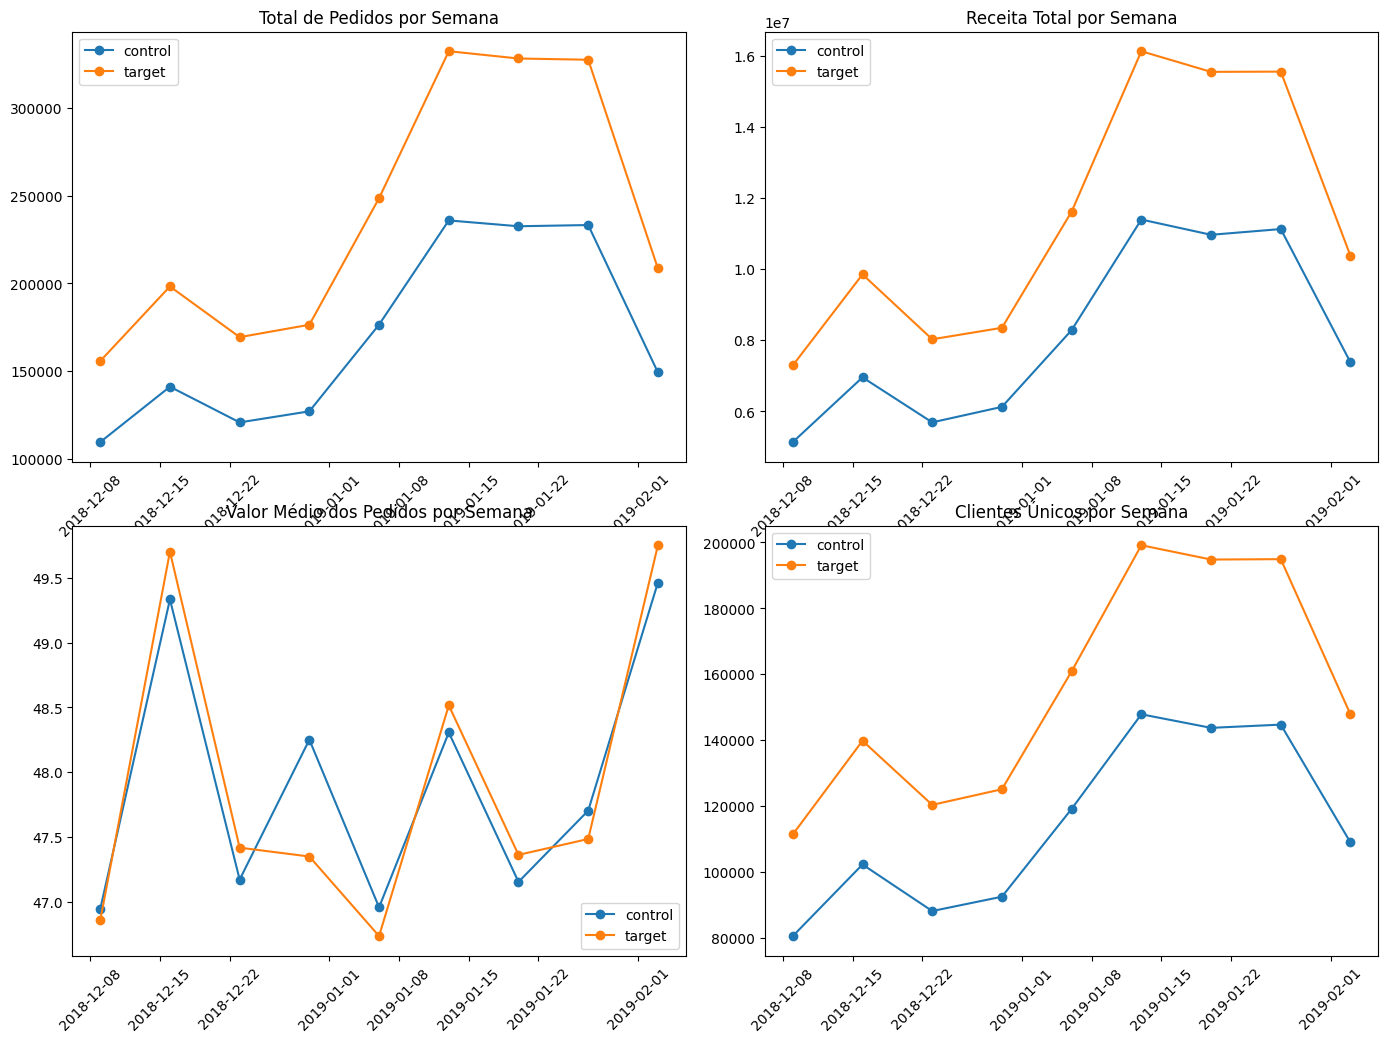

In [22]:
orders_ab['order_created_at'] = pd.to_datetime(orders_ab['order_created_at'])

# Agrupa os dados por semana e is_target
weekly_metrics = orders_ab.groupby([pd.Grouper(key='order_created_at', freq='W'), 'is_target']).agg(
    total_orders=('order_id', 'count'),
    total_revenue=('order_total_amount', 'sum'),
    avg_order_value=('order_total_amount', 'mean'),
    unique_customers=('customer_id', 'nunique')
).reset_index()

# Cria subplots para melhor visualização das métricas semanais
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total de Pedidos por Semana
for grupo in weekly_metrics['is_target'].unique():
    dados = weekly_metrics[weekly_metrics['is_target'] == grupo]
    axes[0, 0].plot(dados['order_created_at'], dados['total_orders'], marker='o', label=grupo)
axes[0, 0].set_title('Total de Pedidos por Semana')
axes[0, 0].legend()

# Receita Total por Semana
for grupo in weekly_metrics['is_target'].unique():
    dados = weekly_metrics[weekly_metrics['is_target'] == grupo]
    axes[0, 1].plot(dados['order_created_at'], dados['total_revenue'], marker='o', label=grupo)
axes[0, 1].set_title('Receita Total por Semana')
axes[0, 1].legend()

# Valor Médio dos Pedidos por Semana
for grupo in weekly_metrics['is_target'].unique():
    dados = weekly_metrics[weekly_metrics['is_target'] == grupo]
    axes[1, 0].plot(dados['order_created_at'], dados['avg_order_value'], marker='o', label=grupo)
axes[1, 0].set_title('Valor Médio dos Pedidos por Semana')
axes[1, 0].legend()

# Clientes Únicos por Semana
for grupo in weekly_metrics['is_target'].unique():
    dados = weekly_metrics[weekly_metrics['is_target'] == grupo]
    axes[1, 1].plot(dados['order_created_at'], dados['unique_customers'], marker='o', label=grupo)
axes[1, 1].set_title('Clientes Únicos por Semana')
axes[1, 1].legend()

plt.tight_layout()

# Rotaciona os rótulos do eixo x em todos os subplots
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()


In [23]:
# Calculando o número de pedidos por cliente e identificando clientes recorrentes
orders_per_customer = orders_ab.groupby(['customer_id', 'is_target'])['order_id'].count().reset_index(name='order_count')
orders_per_customer['repeat_customer'] = orders_per_customer['order_count'] > 1

# Taxa de repetição (retenção) por grupo
repeat_rate = orders_per_customer.groupby('is_target')['repeat_customer'].mean().reset_index(name='repeat_rate')
print(repeat_rate)


  is_target  repeat_rate
0   control     0.747045
1    target     0.795064


In [24]:
# Separando os pedidos dos grupos target e control
target_orders = orders_ab[orders_ab['is_target'] == 'target']['order_total_amount']
control_orders = orders_ab[orders_ab['is_target'] == 'control']['order_total_amount']

# Realizando o teste t para comparação das médias
t_stat, p_value = ttest_ind(target_orders, control_orders, equal_var=False)
print("T-test para valor médio dos pedidos: t = {:.3f}, p = {:.3f}".format(t_stat, p_value))

T-test para valor médio dos pedidos: t = 0.026, p = 0.979


   merchant_state  total_orders  total_restaurants  avg_orders_per_restaurant
4              CE        171543                202                 849.222772
14             PE        144304                179                 806.167598
2              AM         43791                 56                 781.982143
6              ES         82198                115                 714.765217
13             PB         58312                 85                 686.023529
17             RJ        758551               1170                 648.334188
1              AL         17187                 29                 592.655172
3              BA         94624                190                 498.021053
22             SP       1522123               3127                 486.767829
12             PA         22776                 50                 455.520000
16             PR        166943                372                 448.771505
19             RS        108995                251              

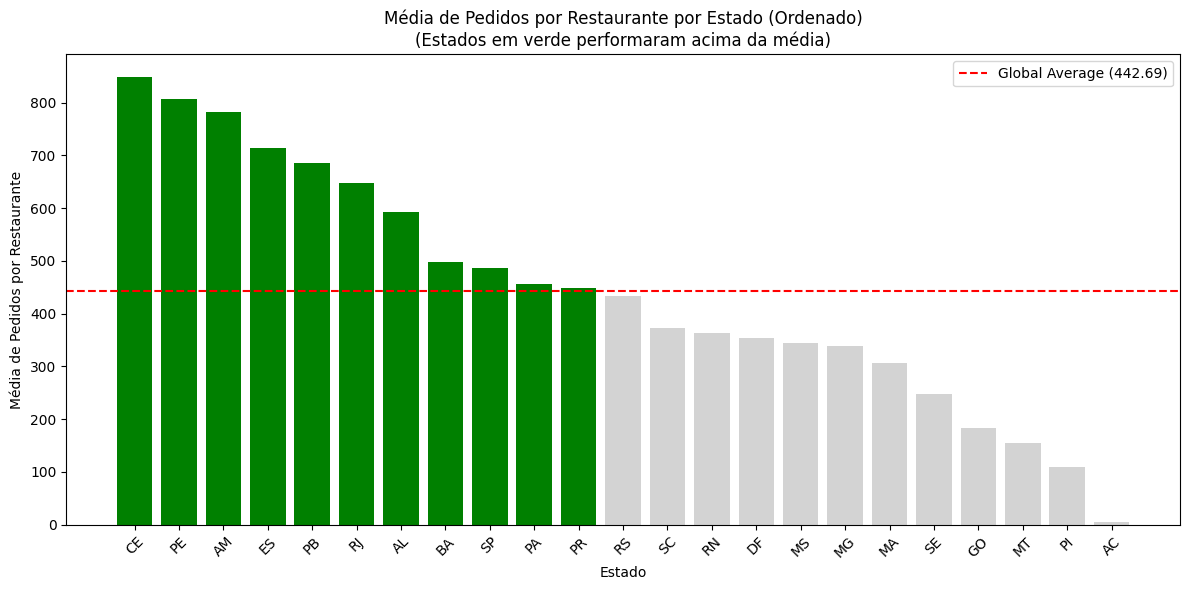

In [25]:
# 1. Unir os dados de pedidos com a informação de estado dos restaurantes
df_orders_rest = df_orders.merge(
    df_restaurant[['id', 'merchant_state']],
    left_on='merchant_id',
    right_on='id',
    how='left'
)

# 2. Agregar o total de pedidos por estado
orders_by_state = df_orders_rest.groupby('merchant_state').agg(
    total_orders=('order_id', 'count')
).reset_index()

# 3. Calcular o número de restaurantes por estado
rest_count = df_restaurant.groupby('merchant_state').agg(
    total_restaurants=('id', 'nunique')
).reset_index()

# 4. Combinar as informações e calcular a média de pedidos por restaurante
orders_by_state = orders_by_state.merge(rest_count, on='merchant_state', how='left')
orders_by_state['avg_orders_per_restaurant'] = orders_by_state['total_orders'] / orders_by_state['total_restaurants']

# Ordenar o DataFrame pela média de pedidos por restaurante, em ordem decrescente
orders_by_state_sorted = orders_by_state.sort_values('avg_orders_per_restaurant', ascending=False)
print(orders_by_state_sorted)

# 5. Análise comparativa: linha média e estados acima da média
global_avg = orders_by_state_sorted['avg_orders_per_restaurant'].mean()
print("Global average orders per restaurant:", global_avg)

above_avg_states = orders_by_state_sorted[orders_by_state_sorted['avg_orders_per_restaurant'] > global_avg]['merchant_state'].tolist()
print("States above average:", above_avg_states)

# 6. Visualização: Gráfico de barras ordenado com linha média global
plt.figure(figsize=(12, 6))
colors = ['green' if state in above_avg_states else 'lightgray' for state in orders_by_state_sorted['merchant_state']]
plt.bar(orders_by_state_sorted['merchant_state'], orders_by_state_sorted['avg_orders_per_restaurant'], color=colors)

plt.axhline(global_avg, color='red', linestyle='--', label=f'Global Average ({global_avg:.2f})')

plt.xlabel("Estado")
plt.ylabel("Média de Pedidos por Restaurante")
plt.title("Média de Pedidos por Restaurante por Estado (Ordenado)\n(Estados em verde performaram acima da média)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_2637/4104322579.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_group['merchant_state'], rotation=45)
/tmp/ipykernel_2637/4104322579.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_group['merchant_state'], rotation=45)


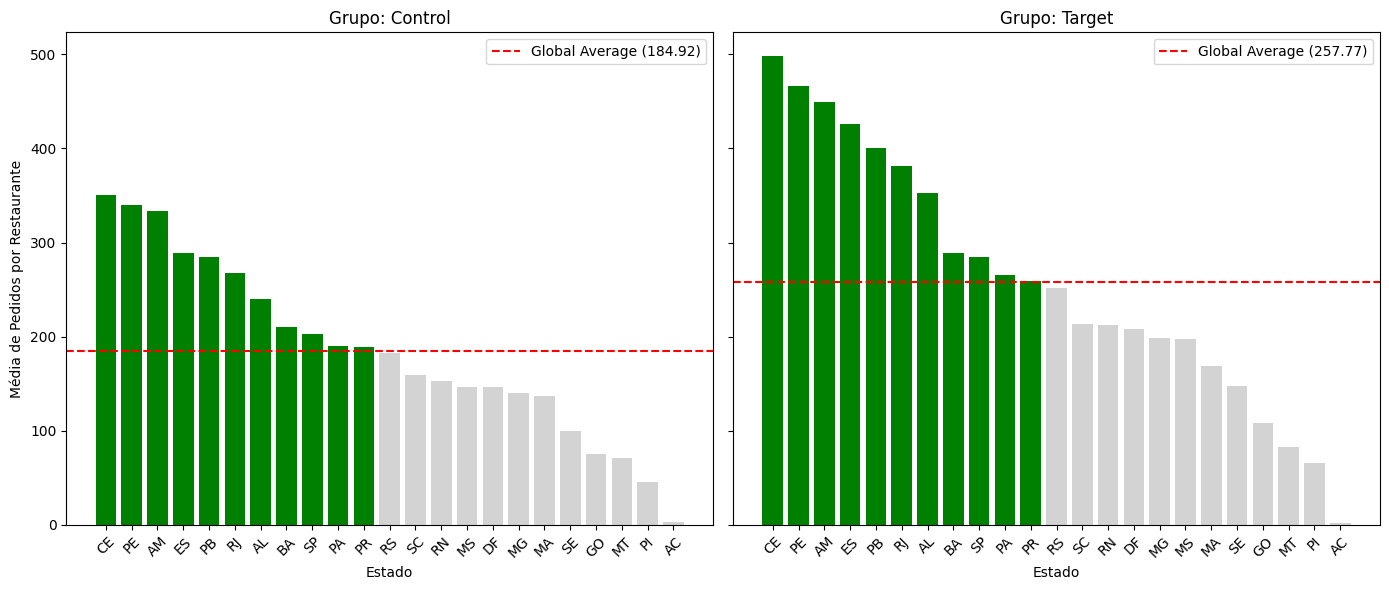

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'orders_ab' e 'df_restaurants' já estejam carregados:
# orders_ab: contém os pedidos do teste A/B (com colunas 'order_id', 'merchant_id', 'order_total_amount', 'is_target', etc.)
# df_restaurants: contém os dados dos restaurantes (com colunas 'id' e 'merchant_state')

# 1. Unir os dados de orders_ab com a informação de estado dos restaurantes
orders_ab_rest = orders_ab.merge(
    df_restaurant[['id', 'merchant_state']],
    left_on='merchant_id',
    right_on='id',
    how='left'
)

# 2. Agregar o total de pedidos por estado e por is_target
orders_by_state_is_target = orders_ab_rest.groupby(['merchant_state', 'is_target']).agg(
    total_orders=('order_id', 'count')
).reset_index()

# 3. Calcular o número de restaurantes por estado (dados fixos, independentes do is_target)
rest_count = df_restaurant.groupby('merchant_state').agg(
    total_restaurants=('id', 'nunique')
).reset_index()

# 4. Combinar as informações e calcular a média de pedidos por restaurante para cada grupo de is_target
orders_by_state_is_target = orders_by_state_is_target.merge(rest_count, on='merchant_state', how='left')
orders_by_state_is_target['avg_orders_per_restaurant'] = orders_by_state_is_target['total_orders'] / orders_by_state_is_target['total_restaurants']

# Visualização: Subplots por grupo 'is_target'
is_target_values = orders_by_state_is_target['is_target'].unique()
fig, axes = plt.subplots(1, len(is_target_values), figsize=(14, 6), sharey=True)

# Caso haja somente um grupo, garantimos que axes seja iterável
if len(is_target_values) == 1:
    axes = [axes]

for ax, group in zip(axes, is_target_values):
    # Filtra para o grupo atual e ordena pela média de pedidos por restaurante
    df_group = orders_by_state_is_target[orders_by_state_is_target['is_target'] == group].sort_values('avg_orders_per_restaurant', ascending=False)
    
    # Calcula a média global do grupo para essa métrica
    global_avg = df_group['avg_orders_per_restaurant'].mean()
    
    # Identifica os estados com performance acima da média para o grupo
    above_avg_states = df_group[df_group['avg_orders_per_restaurant'] > global_avg]['merchant_state'].tolist()
    
    # Define cores: estados acima da média em verde, os demais em azul claro
    colors = ['green' if state in above_avg_states else 'lightgray' for state in df_group['merchant_state']]
    
    # Plotagem do gráfico de barras
    ax.bar(df_group['merchant_state'], df_group['avg_orders_per_restaurant'], color=colors)
    ax.axhline(global_avg, color='red', linestyle='--', label=f'Global Average ({global_avg:.2f})')
    ax.set_title(f"Grupo: {group.capitalize()}")
    ax.set_xlabel("Estado")
    ax.set_xticklabels(df_group['merchant_state'], rotation=45)
    ax.legend()

axes[0].set_ylabel("Média de Pedidos por Restaurante")
plt.tight_layout()
plt.show()


/tmp/ipykernel_2637/487215099.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_group['merchant_state'], rotation=45)
/tmp/ipykernel_2637/487215099.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_group['merchant_state'], rotation=45)


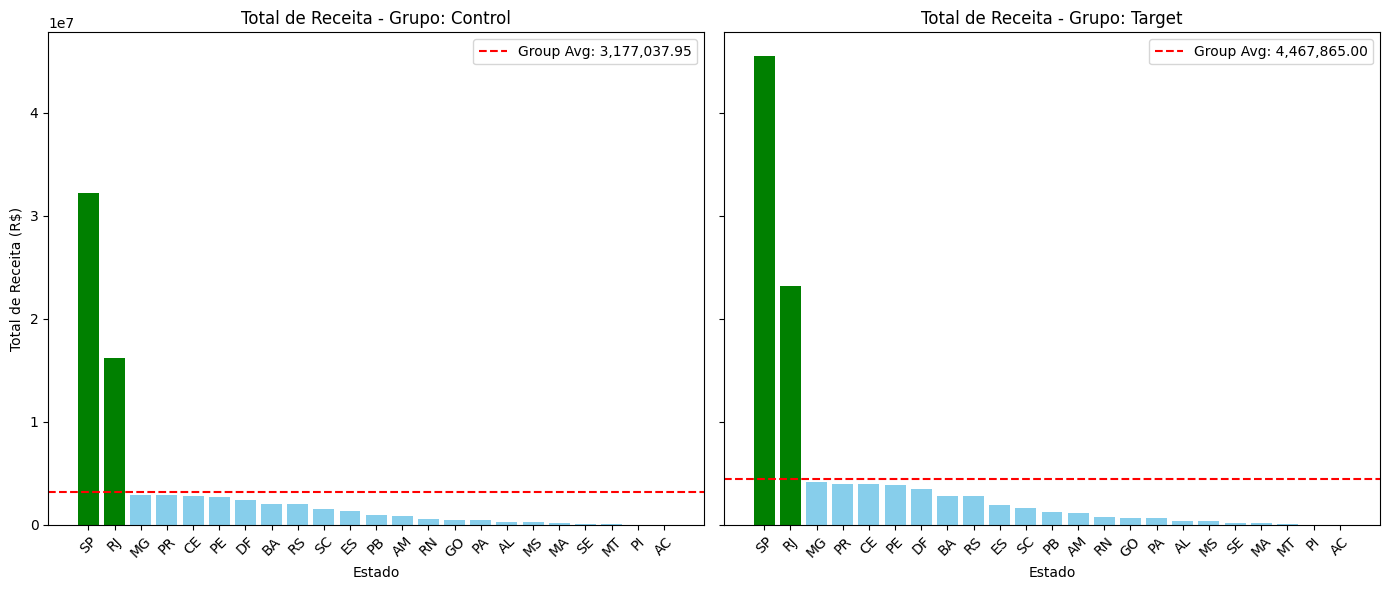

In [ ]:
# 1. Unir os dados de orders_ab com a informação de estado dos restaurantes
orders_ab_rest = orders_ab.merge(
    df_restaurant[['id', 'merchant_state']],
    left_on='merchant_id',
    right_on='id',
    how='left'
)

# 2. Agregar a soma da receita por estado e por is_target
revenue_by_state_is_target = orders_ab_rest.groupby(['merchant_state', 'is_target']).agg(
    total_revenue=('order_total_amount', 'sum')
).reset_index()

# 3. Visualização: Subplots por grupo "is_target" para receita por estado
is_target_values = revenue_by_state_is_target['is_target'].unique()
fig, axes = plt.subplots(1, len(is_target_values), figsize=(14, 6), sharey=True)

# Caso haja somente um grupo, garantir que axes seja iterável
if len(is_target_values) == 1:
    axes = [axes]

for ax, group in zip(axes, is_target_values):
    # Filtra para o grupo atual e ordena pela receita total
    df_group = revenue_by_state_is_target[revenue_by_state_is_target['is_target'] == group].sort_values('total_revenue', ascending=False)
    
    # Calcula a média global de receita para esse grupo
    global_avg_revenue = df_group['total_revenue'].mean()
    
    # Identifica os estados com receita acima da média para o grupo
    above_avg_states = df_group[df_group['total_revenue'] > global_avg_revenue]['merchant_state'].tolist()
    
    # Define as cores: estados acima da média em verde, os demais em azul claro
    colors = ['green' if state in above_avg_states else 'skyblue' for state in df_group['merchant_state']]
    
    # Plotagem do gráfico de barras
    ax.bar(df_group['merchant_state'], df_group['total_revenue'], color=colors)
    ax.axhline(global_avg_revenue, color='red', linestyle='--', label=f'Group Avg: {global_avg_revenue:,.2f}')
    ax.set_title(f"Total de Receita - Grupo: {group.capitalize()}")
    ax.set_xlabel("Estado")
    ax.set_xticklabels(df_group['merchant_state'], rotation=45)
    ax.legend()

axes[0].set_ylabel("Total de Receita (R$)")
plt.tight_layout()
plt.show()


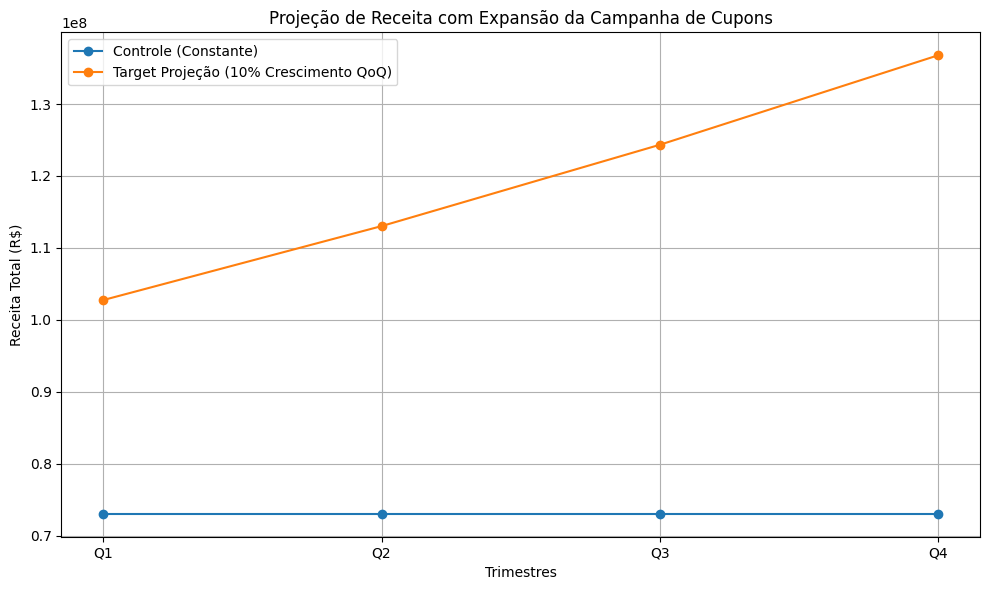

In [ ]:
# Plot 2: Projeção de Receita com Expansão da Campanha
# Projeção de receita para o grupo target, assumindo um crescimento de 10% a cada trimestre.

quarters = ['Q1', 'Q2', 'Q3', 'Q4']
revenue_control = [73.07e6] * 4

# Para o grupo target, iniciamos com a receita observada (~102.76 milhões) e aplicamos um crescimento de 10% QoQ.
revenue_target_projected = [102.76e6 * (1.10 ** i) for i in range(4)]

plt.figure(figsize=(10, 6))
plt.plot(quarters, revenue_control, marker='o', linestyle='-', label='Controle (Constante)')
plt.plot(quarters, revenue_target_projected, marker='o', linestyle='-', label='Target Projeção (10% Crescimento QoQ)')
plt.xlabel('Trimestres')
plt.ylabel('Receita Total (R$)')
plt.title('Projeção de Receita com Expansão da Campanha de Cupons')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


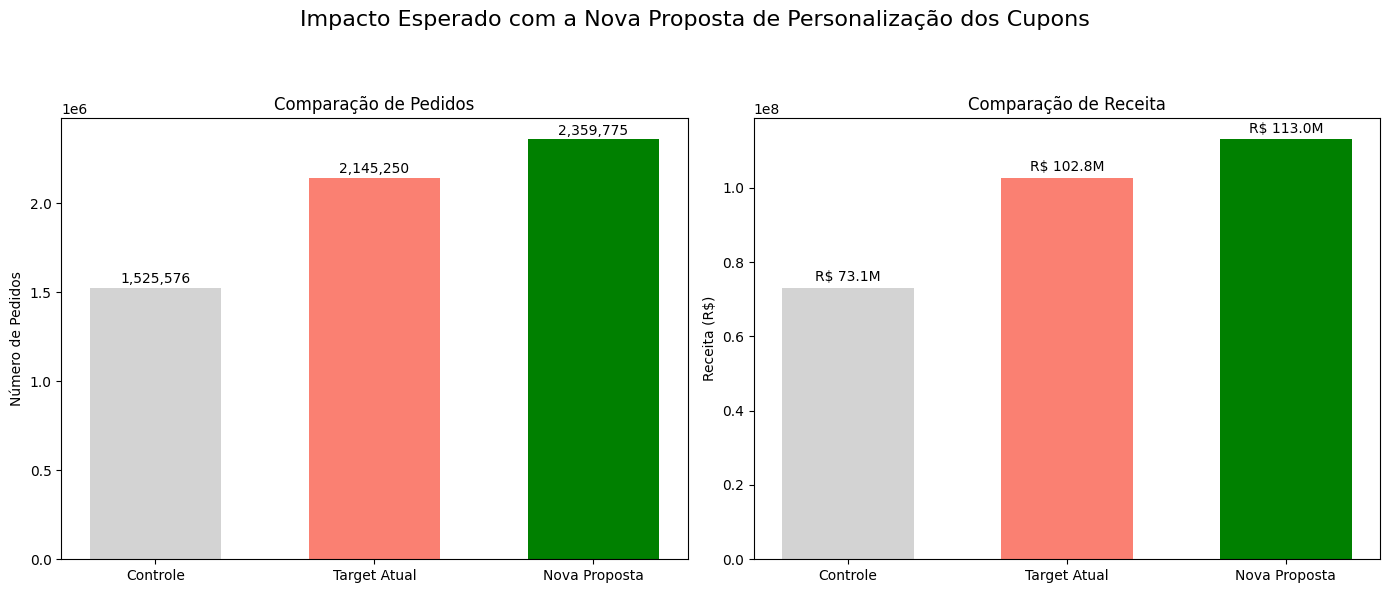

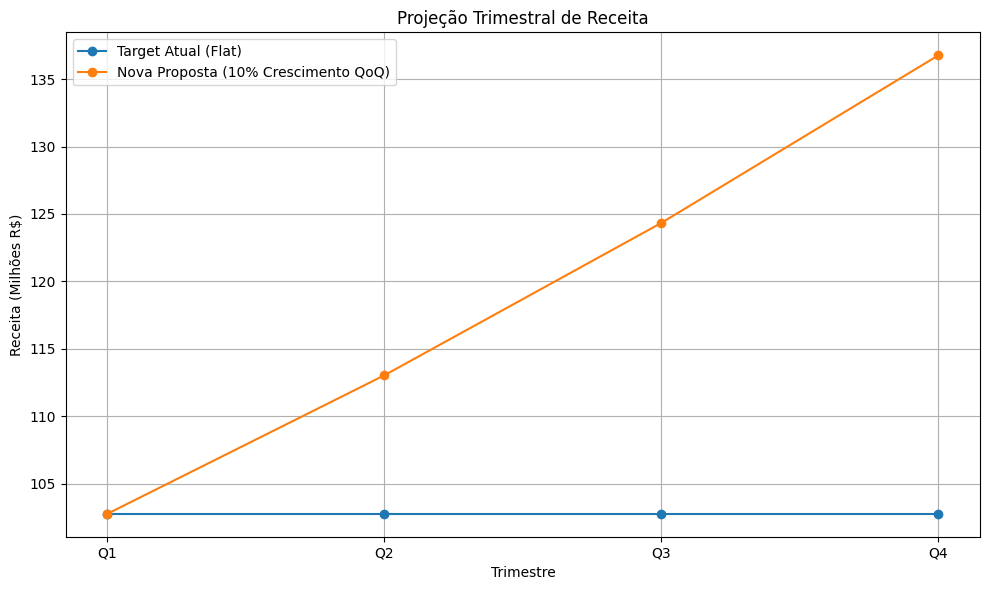

In [29]:
# Hipótese da Nova Proposta:
# Com a personalização dos cupons (ajustando descontos e ofertas por região), espera-se um incremento adicional de 10% nos pedidos e na receita do grupo target.

# Criando um DataFrame com os dados:
data = {
    'Grupo': ['Controle', 'Target Atual', 'Nova Proposta'],
    'Pedidos': [1525576, 2145250, 2145250 * 1.10],   # +10% em pedidos para a Nova Proposta
    'Receita': [73.07e6, 102.76e6, 102.76e6 * 1.10]    # +10% em receita para a Nova Proposta
}

df_proj = pd.DataFrame(data)

# Gráfico 1: Comparação de Pedidos e Receita

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de Barras para Pedidos
colors_pedidos = ['lightgray', 'salmon', 'green']
axes[0].bar(df_proj['Grupo'], df_proj['Pedidos'], color=colors_pedidos, width=0.6)
axes[0].set_title('Comparação de Pedidos')
axes[0].set_ylabel('Número de Pedidos')
for i, v in enumerate(df_proj['Pedidos']):
    axes[0].text(i, v + 10000, f'{int(v):,}', ha='center', va='bottom', fontsize=10)

# Gráfico de Barras para Receita
colors_receita = ['lightgray', 'salmon', 'green']
axes[1].bar(df_proj['Grupo'], df_proj['Receita'], color=colors_receita, width=0.6)
axes[1].set_title('Comparação de Receita')
axes[1].set_ylabel('Receita (R$)')
for i, v in enumerate(df_proj['Receita']):
    axes[1].text(i, v + 1e6, f'R$ {v/1e6:.1f}M', ha='center', va='bottom', fontsize=10)

plt.suptitle('Impacto Esperado com a Nova Proposta de Personalização dos Cupons', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# Gráfico 2: Projeção Trimestral de Receita com Nova Proposta

# Supondo que a receita do grupo target atual seja mantida constante sem personalização, e que a nova proposta gere um crescimento de 10% a cada trimestre.
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

# Receita atual do grupo target (sem crescimento)
revenue_target = [102.76e6] * 4

# Projeção de receita com a nova proposta (10% crescimento a cada trimestre)
revenue_nova = [102.76e6 * (1.10 ** i) for i in range(4)]

plt.figure(figsize=(10, 6))
plt.plot(quarters, [r/1e6 for r in revenue_target], marker='o', linestyle='-', label='Target Atual (Flat)')
plt.plot(quarters, [r/1e6 for r in revenue_nova], marker='o', linestyle='-', label='Nova Proposta (10% Crescimento QoQ)')
plt.xlabel('Trimestre')
plt.ylabel('Receita (Milhões R$)')
plt.title('Projeção Trimestral de Receita')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
